# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

[2018-01-08 23:10:21,848] Making new env: CartPole-v0


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.action_space

Discrete(2)

In [37]:
env.reset()
rewards = []
for _ in range(100):
    env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

In [35]:
env.close()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [23]:
print(rewards)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [38]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [39]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [40]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [41]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [42]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

In [58]:
memory.buffer

deque([(array([-0.00259928,  0.2251672 ,  0.01891555, -0.30396074]),
        1,
        1.0,
        array([ 0.00190406,  0.42001455,  0.01283634, -0.59061863])),
       (array([ 0.00190406,  0.42001455,  0.01283634, -0.59061863]),
        0,
        1.0,
        array([ 0.01030436,  0.22471525,  0.00102397, -0.29392003])),
       (array([ 0.01030436,  0.22471525,  0.00102397, -0.29392003]),
        0,
        1.0,
        array([ 0.01479866,  0.02957871, -0.00485443, -0.00091434])),
       (array([ 0.01479866,  0.02957871, -0.00485443, -0.00091434]),
        0,
        1.0,
        array([ 0.01539023, -0.16547329, -0.00487272,  0.29023301])),
       (array([ 0.01539023, -0.16547329, -0.00487272,  0.29023301]),
        1,
        1.0,
        array([ 0.01208077,  0.02971781,  0.00093194, -0.00398272])),
       (array([ 0.01208077,  0.02971781,  0.00093194, -0.00398272]),
        1,
        1.0,
        array([ 0.01267513,  0.22482638,  0.00085229, -0.29637147])),
       (array([ 0.0126

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [72]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))

                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)


            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")


Episode: 1 Total reward: 47.0 Training loss: 1.0870 Explore P: 0.9954
Episode: 2 Total reward: 19.0 Training loss: 1.1555 Explore P: 0.9935
Episode: 3 Total reward: 11.0 Training loss: 1.0182 Explore P: 0.9924
Episode: 4 Total reward: 18.0 Training loss: 1.1262 Explore P: 0.9906
Episode: 5 Total reward: 17.0 Training loss: 1.1548 Explore P: 0.9890
Episode: 6 Total reward: 16.0 Training loss: 1.1005 Explore P: 0.9874
Episode: 7 Total reward: 15.0 Training loss: 1.2357 Explore P: 0.9859
Episode: 8 Total reward: 24.0 Training loss: 1.3411 Explore P: 0.9836
Episode: 9 Total reward: 39.0 Training loss: 1.1964 Explore P: 0.9798
Episode: 10 Total reward: 23.0 Training loss: 1.6388 Explore P: 0.9776
Episode: 11 Total reward: 34.0 Training loss: 1.4002 Explore P: 0.9743
Episode: 12 Total reward: 17.0 Training loss: 1.4382 Explore P: 0.9727
Episode: 13 Total reward: 11.0 Training loss: 1.4473 Explore P: 0.9716
Episode: 14 Total reward: 22.0 Training loss: 1.5516 Explore P: 0.9695
Episode: 15 Tot

Episode: 119 Total reward: 12.0 Training loss: 4.9220 Explore P: 0.7993
Episode: 120 Total reward: 15.0 Training loss: 51.7561 Explore P: 0.7981
Episode: 121 Total reward: 17.0 Training loss: 66.4985 Explore P: 0.7967
Episode: 122 Total reward: 10.0 Training loss: 59.2012 Explore P: 0.7960
Episode: 123 Total reward: 10.0 Training loss: 87.6773 Explore P: 0.7952
Episode: 124 Total reward: 12.0 Training loss: 3.4264 Explore P: 0.7942
Episode: 125 Total reward: 26.0 Training loss: 38.1530 Explore P: 0.7922
Episode: 126 Total reward: 29.0 Training loss: 21.0480 Explore P: 0.7899
Episode: 127 Total reward: 11.0 Training loss: 181.4982 Explore P: 0.7891
Episode: 128 Total reward: 12.0 Training loss: 4.0685 Explore P: 0.7881
Episode: 129 Total reward: 11.0 Training loss: 3.8889 Explore P: 0.7873
Episode: 130 Total reward: 8.0 Training loss: 49.4931 Explore P: 0.7867
Episode: 131 Total reward: 26.0 Training loss: 39.6751 Explore P: 0.7846
Episode: 132 Total reward: 16.0 Training loss: 3.1003 E

Episode: 238 Total reward: 18.0 Training loss: 26.5214 Explore P: 0.6504
Episode: 239 Total reward: 14.0 Training loss: 55.5349 Explore P: 0.6495
Episode: 240 Total reward: 13.0 Training loss: 2.3525 Explore P: 0.6487
Episode: 241 Total reward: 14.0 Training loss: 2.1026 Explore P: 0.6478
Episode: 242 Total reward: 11.0 Training loss: 1.6934 Explore P: 0.6471
Episode: 243 Total reward: 17.0 Training loss: 113.2158 Explore P: 0.6460
Episode: 244 Total reward: 13.0 Training loss: 53.1299 Explore P: 0.6452
Episode: 245 Total reward: 10.0 Training loss: 1.8235 Explore P: 0.6445
Episode: 246 Total reward: 21.0 Training loss: 90.8517 Explore P: 0.6432
Episode: 247 Total reward: 43.0 Training loss: 24.0104 Explore P: 0.6405
Episode: 248 Total reward: 20.0 Training loss: 1.7173 Explore P: 0.6392
Episode: 249 Total reward: 17.0 Training loss: 1.2671 Explore P: 0.6382
Episode: 250 Total reward: 12.0 Training loss: 1.3811 Explore P: 0.6374
Episode: 251 Total reward: 29.0 Training loss: 1.7428 Exp

Episode: 351 Total reward: 46.0 Training loss: 48.8258 Explore P: 0.4459
Episode: 352 Total reward: 133.0 Training loss: 11.5751 Explore P: 0.4401
Episode: 353 Total reward: 167.0 Training loss: 1.2294 Explore P: 0.4330
Episode: 354 Total reward: 51.0 Training loss: 16.1483 Explore P: 0.4309
Episode: 355 Total reward: 31.0 Training loss: 1.0005 Explore P: 0.4296
Episode: 356 Total reward: 33.0 Training loss: 1.9598 Explore P: 0.4282
Episode: 357 Total reward: 108.0 Training loss: 1.4846 Explore P: 0.4237
Episode: 358 Total reward: 75.0 Training loss: 3.5275 Explore P: 0.4206
Episode: 359 Total reward: 40.0 Training loss: 2.0299 Explore P: 0.4190
Episode: 360 Total reward: 59.0 Training loss: 39.6062 Explore P: 0.4165
Episode: 361 Total reward: 75.0 Training loss: 1.3519 Explore P: 0.4135
Episode: 362 Total reward: 43.0 Training loss: 40.3318 Explore P: 0.4118
Episode: 363 Total reward: 31.0 Training loss: 45.7029 Explore P: 0.4105
Episode: 364 Total reward: 22.0 Training loss: 71.5493 

Episode: 464 Total reward: 93.0 Training loss: 1.9838 Explore P: 0.2398
Episode: 465 Total reward: 34.0 Training loss: 1.6588 Explore P: 0.2390
Episode: 466 Total reward: 147.0 Training loss: 1.0857 Explore P: 0.2357
Episode: 467 Total reward: 71.0 Training loss: 40.0215 Explore P: 0.2341
Episode: 468 Total reward: 136.0 Training loss: 37.7062 Explore P: 0.2311
Episode: 469 Total reward: 100.0 Training loss: 2.7598 Explore P: 0.2289
Episode: 470 Total reward: 50.0 Training loss: 1.5070 Explore P: 0.2278
Episode: 471 Total reward: 97.0 Training loss: 54.6786 Explore P: 0.2257
Episode: 472 Total reward: 130.0 Training loss: 38.1399 Explore P: 0.2229
Episode: 473 Total reward: 112.0 Training loss: 0.9978 Explore P: 0.2205
Episode: 474 Total reward: 101.0 Training loss: 0.9910 Explore P: 0.2184
Episode: 475 Total reward: 61.0 Training loss: 1.3651 Explore P: 0.2171
Episode: 476 Total reward: 117.0 Training loss: 29.2211 Explore P: 0.2147
Episode: 477 Total reward: 148.0 Training loss: 0.57

Episode: 579 Total reward: 105.0 Training loss: 0.3648 Explore P: 0.0707
Episode: 580 Total reward: 42.0 Training loss: 0.2446 Explore P: 0.0704
Episode: 581 Total reward: 55.0 Training loss: 0.5199 Explore P: 0.0701
Episode: 582 Total reward: 37.0 Training loss: 78.8236 Explore P: 0.0699
Episode: 583 Total reward: 31.0 Training loss: 0.6798 Explore P: 0.0697
Episode: 584 Total reward: 31.0 Training loss: 0.4586 Explore P: 0.0695
Episode: 585 Total reward: 36.0 Training loss: 0.7929 Explore P: 0.0693
Episode: 586 Total reward: 26.0 Training loss: 0.5453 Explore P: 0.0691
Episode: 587 Total reward: 29.0 Training loss: 0.9352 Explore P: 0.0690
Episode: 588 Total reward: 37.0 Training loss: 0.1152 Explore P: 0.0687
Episode: 589 Total reward: 103.0 Training loss: 0.6571 Explore P: 0.0681
Episode: 590 Total reward: 31.0 Training loss: 0.6209 Explore P: 0.0680
Episode: 591 Total reward: 35.0 Training loss: 173.4488 Explore P: 0.0678
Episode: 592 Total reward: 32.0 Training loss: 0.4441 Explo

Episode: 692 Total reward: 199.0 Training loss: 0.3529 Explore P: 0.0261
Episode: 693 Total reward: 199.0 Training loss: 0.8115 Explore P: 0.0258
Episode: 694 Total reward: 199.0 Training loss: 0.3485 Explore P: 0.0255
Episode: 695 Total reward: 199.0 Training loss: 0.6538 Explore P: 0.0252
Episode: 696 Total reward: 199.0 Training loss: 307.0549 Explore P: 0.0249
Episode: 697 Total reward: 199.0 Training loss: 0.4514 Explore P: 0.0246
Episode: 698 Total reward: 199.0 Training loss: 1.0583 Explore P: 0.0243
Episode: 699 Total reward: 199.0 Training loss: 1.3938 Explore P: 0.0240
Episode: 700 Total reward: 199.0 Training loss: 0.8953 Explore P: 0.0237
Episode: 701 Total reward: 169.0 Training loss: 2.6632 Explore P: 0.0235
Episode: 702 Total reward: 25.0 Training loss: 2.4935 Explore P: 0.0235
Episode: 703 Total reward: 21.0 Training loss: 1.6420 Explore P: 0.0234
Episode: 704 Total reward: 20.0 Training loss: 2.8324 Explore P: 0.0234
Episode: 705 Total reward: 16.0 Training loss: 2.409

Episode: 805 Total reward: 115.0 Training loss: 255.1688 Explore P: 0.0192
Episode: 806 Total reward: 127.0 Training loss: 4.9059 Explore P: 0.0191
Episode: 807 Total reward: 130.0 Training loss: 3.1704 Explore P: 0.0190
Episode: 808 Total reward: 140.0 Training loss: 4.6175 Explore P: 0.0188
Episode: 809 Total reward: 151.0 Training loss: 1.7688 Explore P: 0.0187
Episode: 810 Total reward: 152.0 Training loss: 196.2867 Explore P: 0.0186
Episode: 811 Total reward: 152.0 Training loss: 173.7287 Explore P: 0.0184
Episode: 812 Total reward: 153.0 Training loss: 2.4727 Explore P: 0.0183
Episode: 813 Total reward: 199.0 Training loss: 3.7881 Explore P: 0.0182
Episode: 814 Total reward: 199.0 Training loss: 4.9672 Explore P: 0.0180
Episode: 815 Total reward: 199.0 Training loss: 3.8609 Explore P: 0.0178
Episode: 816 Total reward: 195.0 Training loss: 2.1744 Explore P: 0.0177
Episode: 817 Total reward: 199.0 Training loss: 1.3033 Explore P: 0.0175
Episode: 818 Total reward: 199.0 Training los

Episode: 917 Total reward: 199.0 Training loss: 48.4316 Explore P: 0.0110
Episode: 918 Total reward: 199.0 Training loss: 0.2276 Explore P: 0.0110
Episode: 919 Total reward: 199.0 Training loss: 0.2774 Explore P: 0.0110
Episode: 920 Total reward: 199.0 Training loss: 27.3722 Explore P: 0.0110
Episode: 921 Total reward: 199.0 Training loss: 0.2465 Explore P: 0.0110
Episode: 922 Total reward: 199.0 Training loss: 0.2808 Explore P: 0.0109
Episode: 923 Total reward: 199.0 Training loss: 0.5508 Explore P: 0.0109
Episode: 924 Total reward: 199.0 Training loss: 0.4661 Explore P: 0.0109
Episode: 925 Total reward: 199.0 Training loss: 0.3818 Explore P: 0.0109
Episode: 926 Total reward: 199.0 Training loss: 0.1638 Explore P: 0.0109
Episode: 927 Total reward: 199.0 Training loss: 0.3874 Explore P: 0.0108
Episode: 928 Total reward: 199.0 Training loss: 0.3672 Explore P: 0.0108
Episode: 929 Total reward: 199.0 Training loss: 0.2639 Explore P: 0.0108
Episode: 930 Total reward: 199.0 Training loss: 0

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

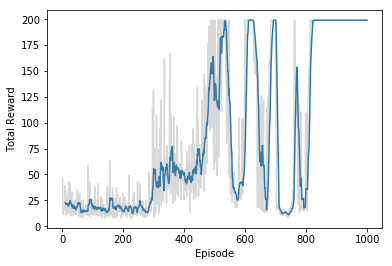

In [75]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

In [67]:
rews

array([  11.,   14.,   13.,   12.,   34.,   30.,   21.,   14.,   30.,
         10.,   52.,   13.,   15.,   14.,   10.,   10.,   13.,   19.,
         26.,   14.,    8.,   16.,   23.,   10.,   22.,   11.,   14.,
         21.,   52.,    9.,    9.,   23.,   23.,   12.,   35.,   23.,
         19.,   40.,   18.,   28.,   18.,   13.,    8.,   31.,   26.,
         20.,   19.,   14.,   15.,    8.,   14.,   12.,    9.,   11.,
         15.,   17.,   12.,   15.,   24.,   14.,   53.,   25.,    9.,
         22.,   31.,   24.,   23.,   26.,   12.,   12.,   10.,   14.,
         16.,    9.,   20.,    9.,   41.,   32.,   49.,   32.,   12.,
         16.,   19.,   14.,   16.,   22.,   17.,   14.,   11.,   22.,
         11.,   15.,   24.,   23.,   11.,   24.,   55.,   33.,   23.,
         14.,   28.,   10.,   19.,   41.,   14.,   14.,   31.,   11.,
         24.,   17.,   11.,   49.,   19.,   21.,   18.,   24.,   21.,
         11.,   19.,   11.,    9.,   45.,   35.,   23.,   41.,   18.,
         17.,   14.,

## Testing

Let's checkout how our trained agent plays the game.

In [8]:
saver = tf.train.Saver()
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


[2018-01-07 00:22:22,634] Restoring parameters from checkpoints/cartpole.ckpt


NameError: name 'state' is not defined

In [184]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.